# KG Visual Insights

This notebook explores the exported knowledge-graph datasets to surface a few quick visual insights. The examples below focus on the Neo4j exports provided in `data/exports/neo4j`.


## Data Files Used
- `places.csv`: metadata for each place node, including location and type.
- `place_reviews.jsonl`: reviews and ratings linked to places and cities.
- `cities.csv`: lookup table with city names and bounding boxes.


In [11]:
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    WordCloud = None
    WORDCLOUD_AVAILABLE = False

try:
    import geopandas as gpd
    from shapely.geometry import Point
    GEOPANDAS_AVAILABLE = True
except ImportError:
    gpd = None
    Point = None
    GEOPANDAS_AVAILABLE = False

try:
    from nltk.corpus import stopwords as nltk_stopwords
    NLTK_STOPWORDS_AVAILABLE = True
except ImportError:
    nltk_stopwords = None
    NLTK_STOPWORDS_AVAILABLE = False

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [12]:
def find_project_root(marker: str = "data/exports/neo4j") -> Path:
    current = Path.cwd().resolve()
    marker_path = Path(marker)
    while True:
        if (current / marker_path).exists():
            return current
        if current.parent == current:
            raise FileNotFoundError(f"Could not find '{marker}' by walking up from {Path.cwd()}")
        current = current.parent

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / "data/exports/neo4j"
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")


Project root: /Users/chaayagirimon/Shelf/thesis/datasets/kg_etl
Data directory: /Users/chaayagirimon/Shelf/thesis/datasets/kg_etl/data/exports/neo4j


In [13]:
places = pd.read_csv(DATA_DIR / "places.csv")
reviews = pd.read_json(DATA_DIR / "place_reviews.jsonl", lines=True)
cities = pd.read_csv(DATA_DIR / "cities.csv")

reviews["scraped_at"] = pd.to_datetime(reviews.get("scraped_at"), errors="coerce")

print(f"Places: {len(places):,}")
print(f"Reviews: {len(reviews):,}")
print(f"Cities: {len(cities):,}")


Places: 23,160
Reviews: 128,293
Cities: 53


## Dataset Statistics
Quick snapshot of the KG export sizes before diving into the visuals.


In [ ]:
from collections import OrderedDict

summary_rows = [
    {"entity": "Cities", "count": len(cities)},
    {"entity": "Places", "count": len(places)},
    {"entity": "Reviews", "count": len(reviews)},
]

links_path = DATA_DIR / "place_links.csv"
canonical_path = DATA_DIR / "place_canonical_map.csv"

edge_rows = []
if links_path.exists():
    place_links = pd.read_csv(links_path)
    # count unique place-to-place edges
    unique_links = place_links.drop_duplicates(subset=["a", "b"])
    edge_rows.append({
        "edge_type": "PLACE_LINK", "count": len(unique_links)
    })
if canonical_path.exists():
    place_canonical = pd.read_csv(canonical_path)
    edge_rows.append({
        "edge_type": "PLACE_TO_CANONICAL", "count": len(place_canonical)
    })

# each review links to a place (and indirectly to a city)
edge_rows.append({
    "edge_type": "REVIEW_OF_PLACE", "count": len(reviews.dropna(subset=["place_id"]))
})

nodes_df = pd.DataFrame(summary_rows)
nodes_df.loc[nodes_df.shape[0]] = {
    "entity": "Total nodes (approx.)",
    "count": nodes_df["count"].sum()
}

edges_df = pd.DataFrame(edge_rows)

print("Node counts:")
display(nodes_df)
print("
Edge counts:")
display(edges_df)


In [14]:
city_lookup = cities.set_index("slug")["name"].to_dict()
place_counts = places["city_slug"].value_counts().rename_axis("city_slug").reset_index(name="places")
place_counts["city_name"] = place_counts["city_slug"].map(city_lookup)
place_counts.head()


,city_slug,places,city_name
0,london,2798,London
1,budapest,2186,Budapest
2,stockholm,1284,Stockholm
3,berlin,1008,Berlin
4,vienna,937,Vienna


## Places Per City
The bar chart below highlights which cities currently have the highest number of places represented in the export.


/var/folders/qx/_51n2ry12zgc5txgc6hv8_yr0000gn/T/ipykernel_78441/1880336401.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_cities, y="city", x="places", palette="viridis")


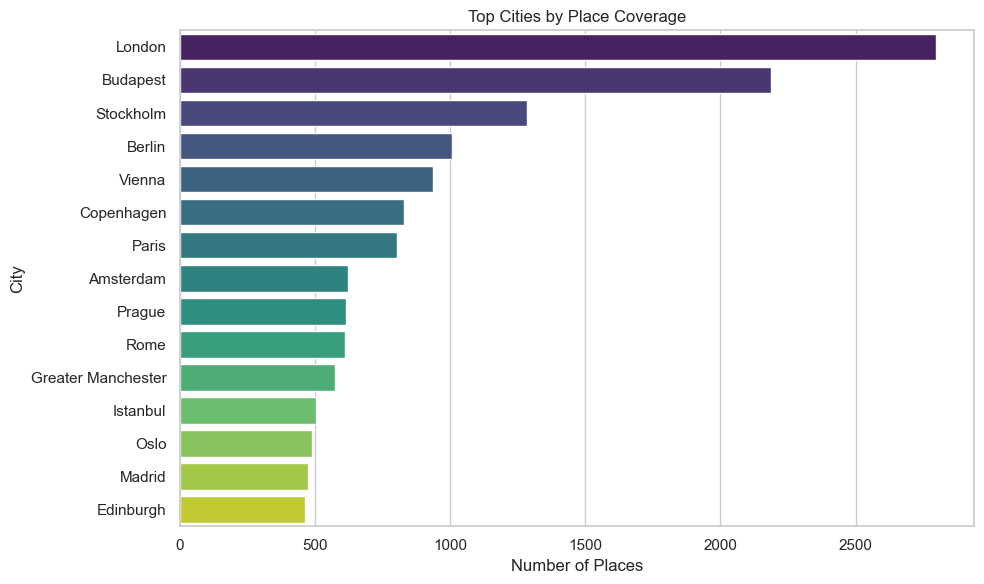

In [15]:
top_cities = place_counts.assign(city=lambda df: df["city_name"].fillna(df["city_slug"]))\
    .head(15)

ax = sns.barplot(data=top_cities, y="city", x="places", palette="viridis")
ax.set(title="Top Cities by Place Coverage", xlabel="Number of Places", ylabel="City")
plt.tight_layout()
plt.show()


## Review Rating Distribution
A quick look at the distribution of review ratings helps gauge the sentiment spread across all cities.


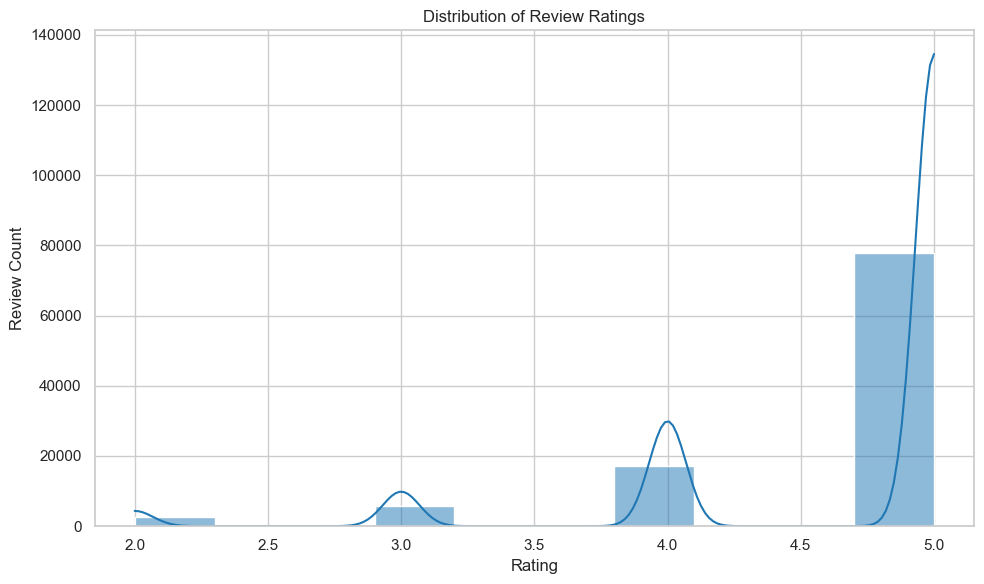

In [16]:
ax = sns.histplot(reviews["rating"], bins=10, kde=True, color="#1f77b4")
ax.set(title="Distribution of Review Ratings", xlabel="Rating", ylabel="Review Count")
plt.tight_layout()
plt.show()


## Average Ratings by City
Aggregating reviews at the city level reveals where visitors report the best experiences. The plot focuses on cities with the largest review volume.


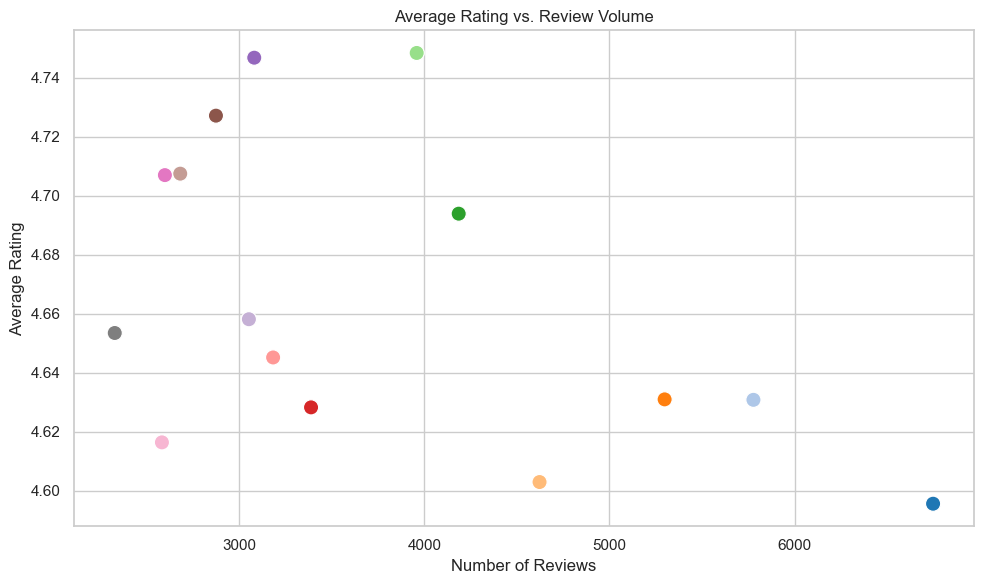

,city,review_count,avg_rating
0,Vienna,6749,4.595644
1,Copenhagen,5778,4.630841
2,Prague,5298,4.630993
3,Amsterdam,4622,4.602986
4,London,4185,4.693907
5,Rome,3958,4.748358
6,Ghent,3387,4.628285
7,Berlin,3182,4.645192
8,Florence,3080,4.746753
9,Paris,3051,4.658145


In [17]:
rating_summary = (
    reviews.groupby("city_slug")["rating"].agg(["count", "mean"])
    .rename(columns={"count": "review_count", "mean": "avg_rating"})
    .sort_values("review_count", ascending=False)
    .head(15)
    .reset_index()
)
rating_summary["city"] = rating_summary["city_slug"].map(city_lookup).fillna(rating_summary["city_slug"])

ax = sns.scatterplot(
    data=rating_summary,
    x="review_count",
    y="avg_rating",
    hue="city",
    palette="tab20",
    s=120,
    legend=False,
)
ax.set(title="Average Rating vs. Review Volume", xlabel="Number of Reviews", ylabel="Average Rating")
plt.tight_layout()
plt.show()

rating_summary.loc[:, ["city", "review_count", "avg_rating"]]


## Review Vocabulary Snapshot
The following cell builds a word cloud for a selected city (or falls back to a frequency bar chart if the `wordcloud` package is unavailable). Adjust `target_city` to explore other locations.


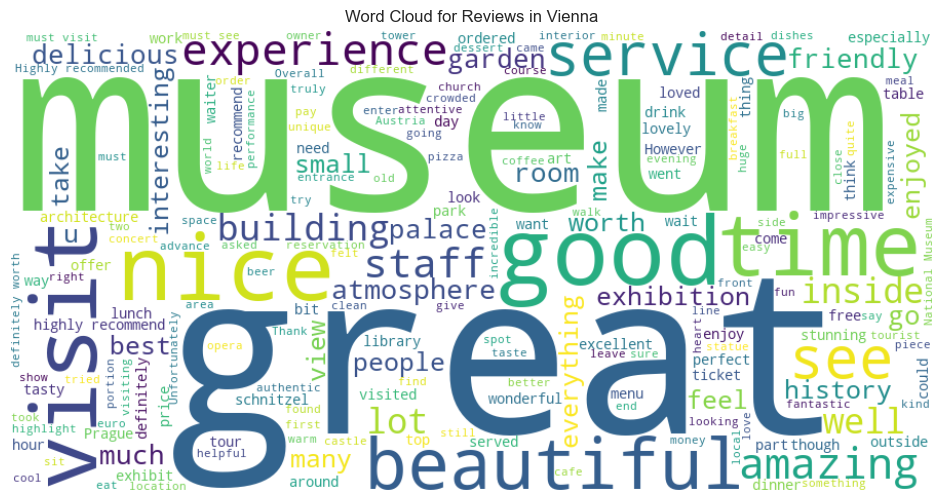

Word cloud available: True
Review count used: 7,894


In [19]:
target_city = "vienna"
city_name = city_lookup.get(target_city, target_city.title())
city_reviews = reviews.loc[reviews["city_slug"] == target_city, "text"].dropna()

if city_reviews.empty:
    raise ValueError(f"No reviews available for city slug '{target_city}'.")

try:
    stopword_list = set(nltk_stopwords.words("english"))
except Exception:
    try:
        import nltk
        nltk.download("stopwords", quiet=True)
        stopword_list = set(nltk_stopwords.words("english"))
    except Exception:
        stopword_list = set()

custom_stopwords = {
    "place", "food", "restaurant", "vienna", "amsterdam", "brussels", "city",
    "really", "also", "one", "get", "got", "would", "like", "even", "back"
}

stopwords = (stopword_list or {
    "the", "and", "to", "of", "a", "in", "for", "is", "it", "on", "that", "with",
    "was", "we", "this", "are", "as", "had", "at", "our", "very", "so", "be",
    "have", "but", "they", "were", "you", "us"
}).union(custom_stopwords)

full_text = " ".join(city_reviews.astype(str))

if WORDCLOUD_AVAILABLE and full_text.strip():
    wc = WordCloud(width=900, height=450, background_color="white", stopwords=stopwords).generate(full_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Reviews in {city_name}")
    plt.show()
else:
    tokens = [
        word.lower()
        for line in city_reviews
        for word in line.split()
    ]
    filtered = [word.strip(".,!?:\"'()[]{}-") for word in tokens]
    filtered = [word for word in filtered if word and word not in stopwords and not word.isdigit()]
    counter = Counter(filtered)
    most_common = counter.most_common(20)
    if not most_common:
        raise ValueError("Not enough tokens to build a frequency chart.")
    words, counts = zip(*most_common)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette="mako")
    plt.title(f"Top Review Terms in {city_name}")
    plt.xlabel("Frequency")
    plt.ylabel("Term")
    plt.tight_layout()
    plt.show()

print(f"Word cloud available: {WORDCLOUD_AVAILABLE}")
print(f"Review count used: {len(city_reviews):,}")


### Next Ideas
- Slice the visuals by `source` (e.g., Yelp vs. Airbnb) to compare sentiment.
- Overlay place locations on a map using `geopandas` or a tile service for spatial patterns.
- Build timeline views by parsing `scraped_at` timestamps to spot activity trends.
